In [1]:
# tf
import tensorflow as tf
from keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# base
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
import scipy

# nltk
import nltk
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [5]:
# read csv's
df_train_origin = pd.read_csv('/train.csv')
#df_test_origin = pd.read_csv('test.csv')

# **Dataset**

In [12]:
df_train_origin.describe()

,Id,Rating
count,60000.000000,60000.00000
mean,29999.500000,3.56255
std,17320.652413,1.82283
min,0.000000,1.00000
25%,14999.750000,1.00000
50%,29999.500000,5.00000
75%,44999.250000,5.00000
max,59999.000000,5.00000


In [13]:
df_train_origin.head()

,Id,Review,Rating
0,0,good value great tv happy delivery next day fr...,5
1,1,month still access account,3
2,2,make official review product app came mum boug...,1
3,3,fantastic extremely easy use website fantastic...,5
4,4,far annoyed hell bt monthly pass easy abc get ...,1


In [14]:
fig = px.pie(data_frame = df_train_origin, 
             names= df_train_origin.Rating.value_counts().index, 
             values= df_train_origin.Rating.value_counts(), 
             title= 'Ratings distribution diagram')
fig.show()

In [7]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=810143c70b4fc09c2a89405bfce5507850e152b1372cb9fef9abeb1e92b519e6
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [8]:
import emoji

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                 -------STOPWORDS WORDS CLOUD-------


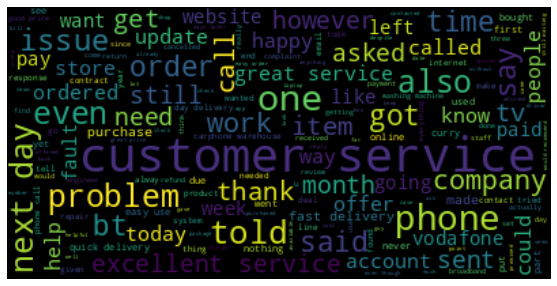

In [16]:
import nltk
from wordcloud import WordCloud
nltk.download('stopwords')
stop = stopwords.words("english")
textt = " ".join(review for review in df_train_origin.Review)
wordcloud = WordCloud(stopwords=stop).generate(textt)
print('                 -------STOPWORDS WORDS CLOUD-------')
plt.rcParams['figure.figsize'] = (10,5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [11]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):    
    x = x.lower()
    x = removeHTML(x)
    x = emoji.demojize(x, delimiters=(" ", " "))
    
    # left only important words
    words = re.findall(r'\w+', x,flags = re.UNICODE) 
    important_words = filter(lambda x: x not in stop, words)
    x = " ".join(important_words) 
    
    x = re.sub("@\w+", '',x) # removing mentions (@)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub(r"[^\w\s]", '',x) # to remove symbols
    x = re.sub("http\w+", '',x)
    x = re.sub("\s[a-z]\s", '',x)
    x = x.strip()
    return x

df_train_origin["Review"] = df_train_origin["Review"].apply(lambda x: dataPreprocessing(x))
# df_test_origin["Review"] = df_test_origin["Review"].apply(lambda x: dataPreprocessing(x))

In [ ]:
df_train_origin.head(5)

,Id,Review,Rating,CharRating
0,0,good value great tv happy delivery next day fr...,5,Postivie
1,1,month still access account,3,Neutral
2,2,make official review product app came mum boug...,1,Negative
3,3,fantastic extremely easy use website fantastic...,5,Postivie
4,4,far annoyed hell bt monthly pass easy abc get ...,1,Negative


In [17]:
# create new features 'Postivie' - 4-5, 'Neutral' - 3, 'Negative' - 1-2
conditions = [
    (df_train_origin['Rating'] < 3),
    (df_train_origin['Rating'] >= 3 ) & (df_train_origin['Rating'] <= 4),
    (df_train_origin['Rating'] == 5)]
choices = ['Negative', 'Neutral', 'Postivie']
df_train_origin['CharRating'] = np.select(conditions, choices, default= 'Unrated')
df_train_origin.head(3)

,Id,Review,Rating,CharRating
0,0,good value great tv happy delivery next day fr...,5,Postivie
1,1,month still access account,3,Neutral
2,2,make official review product app came mum boug...,1,Negative


In [18]:
fig = px.pie(data_frame= df_train_origin.CharRating.value_counts(), 
             values= df_train_origin.CharRating.value_counts(), 
             names= df_train_origin.CharRating.value_counts().index, 
             title= 'CharRatings distribution diagram')
fig.show()

In [19]:
# OHE .Rating and .CharRating
df_train_origin.Rating = pd.Categorical(df_train_origin.Rating)
ohe_columns = pd.get_dummies(df_train_origin[df_train_origin.columns[2:]])
df_modif_train = pd.concat([df_train_origin,ohe_columns], axis= 1)
df_modif_train.head(5)

,Id,Review,Rating,CharRating,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,CharRating_Negative,CharRating_Neutral,CharRating_Postivie
0,0,good value great tv happy delivery next day fr...,5,Postivie,0,0,0,0,1,0,0,1
1,1,month still access account,3,Neutral,0,0,1,0,0,0,1,0
2,2,make official review product app came mum boug...,1,Negative,1,0,0,0,0,1,0,0
3,3,fantastic extremely easy use website fantastic...,5,Postivie,0,0,0,0,1,0,0,1
4,4,far annoyed hell bt monthly pass easy abc get ...,1,Negative,1,0,0,0,0,1,0,0


# **Vectorization**

In [20]:
# create len feature and explore
len_feature = []
for text in df_modif_train.Review.values:
    len_feature.append(len(text))
df_modif_train['Review_Lenght'] = len_feature

In [21]:
# split the data into training and testing sets
# 90% of the data used for training and 10% used for testing
X_train, X_test, y_train, y_test = train_test_split(df_modif_train['Review'], 
                                                    df_modif_train['Rating'], 
                                                    test_size=0.1, random_state=117)
# extract the length of each review in the training and testing sets
X_train_len = df_modif_train.Review_Lenght[X_train.index]
X_test_len = df_modif_train.Review_Lenght[X_test.index]
# scale the review lengths so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_len = scaler.fit_transform(np.array(X_train_len.values).reshape(-1,1))
X_test_len = scaler.transform(np.array(X_test_len.values).reshape(-1,1))

In [22]:
# transform the text of the reviews in the training and testing sets into numerical vectors
cv = CountVectorizer()
X_train_vect = cv.fit_transform(X_train)
X_test_vect = cv.transform(X_test)

In [23]:
# horizontally stack the sparse matrix of token counts (X_train_vect) 
# with an array of the length of each review (X_train_len). 
X_train_vect = scipy.sparse.hstack((X_train_vect,np.array(X_train_len))).A

In [24]:
# converting the dense array representation of the matrix of token counts (X_train_vect)
# into a sparse matrix in Compressed Sparse Row (CSR) format
X_train_vect = scipy.sparse.csr_matrix(X_train_vect)

Upper we added len feature to vectorization

# **Logistic Regression**

In [25]:
model = LogisticRegression(max_iter= 10000)
model.fit(X_train_vect, y_train)

LogisticRegression(max_iter=10000)

In [26]:
X_test_vect = scipy.sparse.hstack((X_test_vect,np.array(X_test_len))).A
X_test_vect = scipy.sparse.csr_matrix(X_test_vect)

In [27]:
# Use model to predict the results of test data
y_pred_class = model.predict(X_test_vect)
accuracy_score(y_test, y_pred_class)

0.854

In [28]:
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=model.predict(X_test_vect))
print(sk_report)

              precision    recall  f1-score   support

           1   0.884755  0.918455  0.901290      1864
           2   0.194690  0.123596  0.151203       178
           3   0.281250  0.150000  0.195652       180
           4   0.261364  0.140244  0.182540       328
           5   0.901359  0.961449  0.930435      3450

    accuracy                       0.854000      6000
   macro avg   0.504683  0.458749  0.472224      6000
weighted avg   0.821646  0.854000  0.835335      6000



# **Multi-layer Perceptron Classifier**

In [29]:
# fit a multi-layer perceptron (MLP) classifier model to the training data
nn_model = MLPClassifier(random_state=117, 
                         max_iter=3, 
                         hidden_layer_sizes= [100,700,200], 
                         early_stopping= True)
nn_model.fit(X_train_vect, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.



MLPClassifier(early_stopping=True, hidden_layer_sizes=[100, 700, 200],
              max_iter=3, random_state=117)

In [30]:
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nn_model.predict(X_test_vect))
print(sk_report)

              precision    recall  f1-score   support

           1   0.857483  0.965129  0.908127      1864
           2   0.000000  0.000000  0.000000       178
           3   0.381818  0.116667  0.178723       180
           4   0.510204  0.076220  0.132626       328
           5   0.894155  0.984348  0.937086      3450

    accuracy                       0.873500      6000
   macro avg   0.528732  0.428473  0.431313      6000
weighted avg   0.819876  0.873500  0.833561      6000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



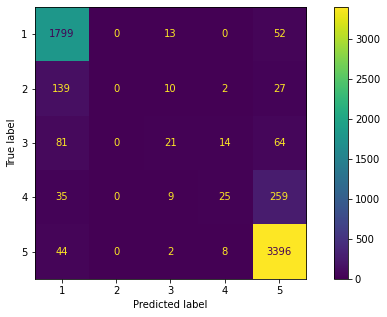

In [31]:
ConfusionMatrixDisplay.from_estimator(nn_model, X_test_vect, y_test)

# **Random Forest**

In [32]:
# fit a Random Forest classifier model to the training data
r_forest = RandomForestClassifier(random_state=117, n_jobs= -1)
r_forest.fit(X_train_vect, y_train)

RandomForestClassifier(n_jobs=-1, random_state=117)

In [33]:
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=r_forest.predict(X_test_vect))
print(sk_report)

              precision    recall  f1-score   support

           1   0.829210  0.935086  0.878971      1864
           2   1.000000  0.005618  0.011173       178
           3   0.000000  0.000000  0.000000       180
           4   0.000000  0.000000  0.000000       328
           5   0.860919  0.972464  0.913298      3450

    accuracy                       0.849833      6000
   macro avg   0.538026  0.382634  0.360688      6000
weighted avg   0.782303  0.849833  0.798545      6000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



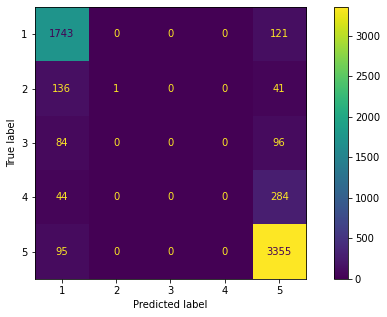

In [34]:
ConfusionMatrixDisplay.from_estimator(r_forest, X_test_vect, y_test)